# Exploratory Data Analysis: NFL Pass Rush Collision Analytics
## Big Data Bowl 2023 - Player Health & Safety Focus

**Goal**: Analyze pass rush collision dynamics to predict pressure events (hits, hurries, sacks) that pose QB injury risk.

**Target Variable**: Rusher generated pressure (binary: hit/hurry/sack = 1, else 0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style to match the reference image
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Increase figure quality
%config InlineBackend.figure_format = 'retina'

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Data Loading

In [2]:
# Load datasets
print("Loading datasets...")

week1 = pd.read_csv('nfl-big-data-bowl-2023/week1.csv')
plays = pd.read_csv('nfl-big-data-bowl-2023/plays.csv')
pff = pd.read_csv('nfl-big-data-bowl-2023/pffScoutingData.csv')
players = pd.read_csv('nfl-big-data-bowl-2023/players.csv')

print(f"✅ Loaded {len(week1):,} tracking records")
print(f"✅ Loaded {len(plays):,} plays")
print(f"✅ Loaded {len(pff):,} PFF records")
print(f"✅ Loaded {len(players):,} players")

Loading datasets...
✅ Loaded 1,118,122 tracking records
✅ Loaded 8,557 plays
✅ Loaded 188,254 PFF records
✅ Loaded 1,679 players


## 2. Create Target Variable & Feature Engineering

In [3]:
# Focus on pass rushers
rushers = pff[pff['pff_role'] == 'Pass Rush'].copy()
blockers = pff[pff['pff_role'] == 'Pass Block'].copy()

# Create target variable: rusher generated pressure
rushers['generated_pressure'] = (
    (rushers['pff_hit'] == 1) |
    (rushers['pff_hurry'] == 1) |
    (rushers['pff_sack'] == 1)
).astype(int)

# Create pressure type labels
def get_pressure_type(row):
    if row['pff_sack'] == 1:
        return 'Sack'
    elif row['pff_hit'] == 1:
        return 'Hit'
    elif row['pff_hurry'] == 1:
        return 'Hurry'
    else:
        return 'No Pressure'

rushers['pressure_type'] = rushers.apply(get_pressure_type, axis=1)

# Merge with play context
rushers = rushers.merge(
    plays[['gameId', 'playId', 'passResult', 'down', 'yardsToGo', 
           'defendersInBox', 'offenseFormation', 'pff_passCoverageType']],
    on=['gameId', 'playId'],
    how='left'
)

# Blocker outcomes
blockers['allowed_pressure'] = (
    (blockers['pff_hitAllowed'] == 1) |
    (blockers['pff_hurryAllowed'] == 1) |
    (blockers['pff_sackAllowed'] == 1)
).astype(int)

print(f"Total rush attempts: {len(rushers):,}")
print(f"Pressure events: {rushers['generated_pressure'].sum():,} ({rushers['generated_pressure'].mean()*100:.2f}%)")
print(f"\nClass balance: {rushers['generated_pressure'].mean()*100:.1f}% positive, {(1-rushers['generated_pressure'].mean())*100:.1f}% negative")

Total rush attempts: 36,362
Pressure events: 4,232 (11.64%)

Class balance: 11.6% positive, 88.4% negative


## 3. Summary Statistics

In [4]:
# Calculate summary stats
total_rushes = len(rushers)
total_pressures = rushers['generated_pressure'].sum()
pressure_rate = rushers['generated_pressure'].mean()

hits = (rushers['pff_hit'] == 1).sum()
hurries = (rushers['pff_hurry'] == 1).sum()
sacks = (rushers['pff_sack'] == 1).sum()

print("="*70)
print("DATASET SUMMARY")
print("="*70)
print(f"Total rush attempts: {total_rushes:,}")
print(f"Pressure events: {total_pressures:,}")
print(f"Pressure rate: {pressure_rate*100:.2f}%")
print(f"\nBreakdown:")
print(f"  Hits: {hits:,} ({hits/total_rushes*100:.2f}%)")
print(f"  Hurries: {hurries:,} ({hurries/total_rushes*100:.2f}%)")
print(f"  Sacks: {sacks:,} ({sacks/total_rushes*100:.2f}%)")

DATASET SUMMARY
Total rush attempts: 36,362
Pressure events: 4,232
Pressure rate: 11.64%

Breakdown:
  Hits: 823 (2.26%)
  Hurries: 2,824 (7.77%)
  Sacks: 585 (1.61%)


## 4. Comprehensive Visualization Dashboard

✅ Saved: pass_rush_collision_eda_comprehensive.png


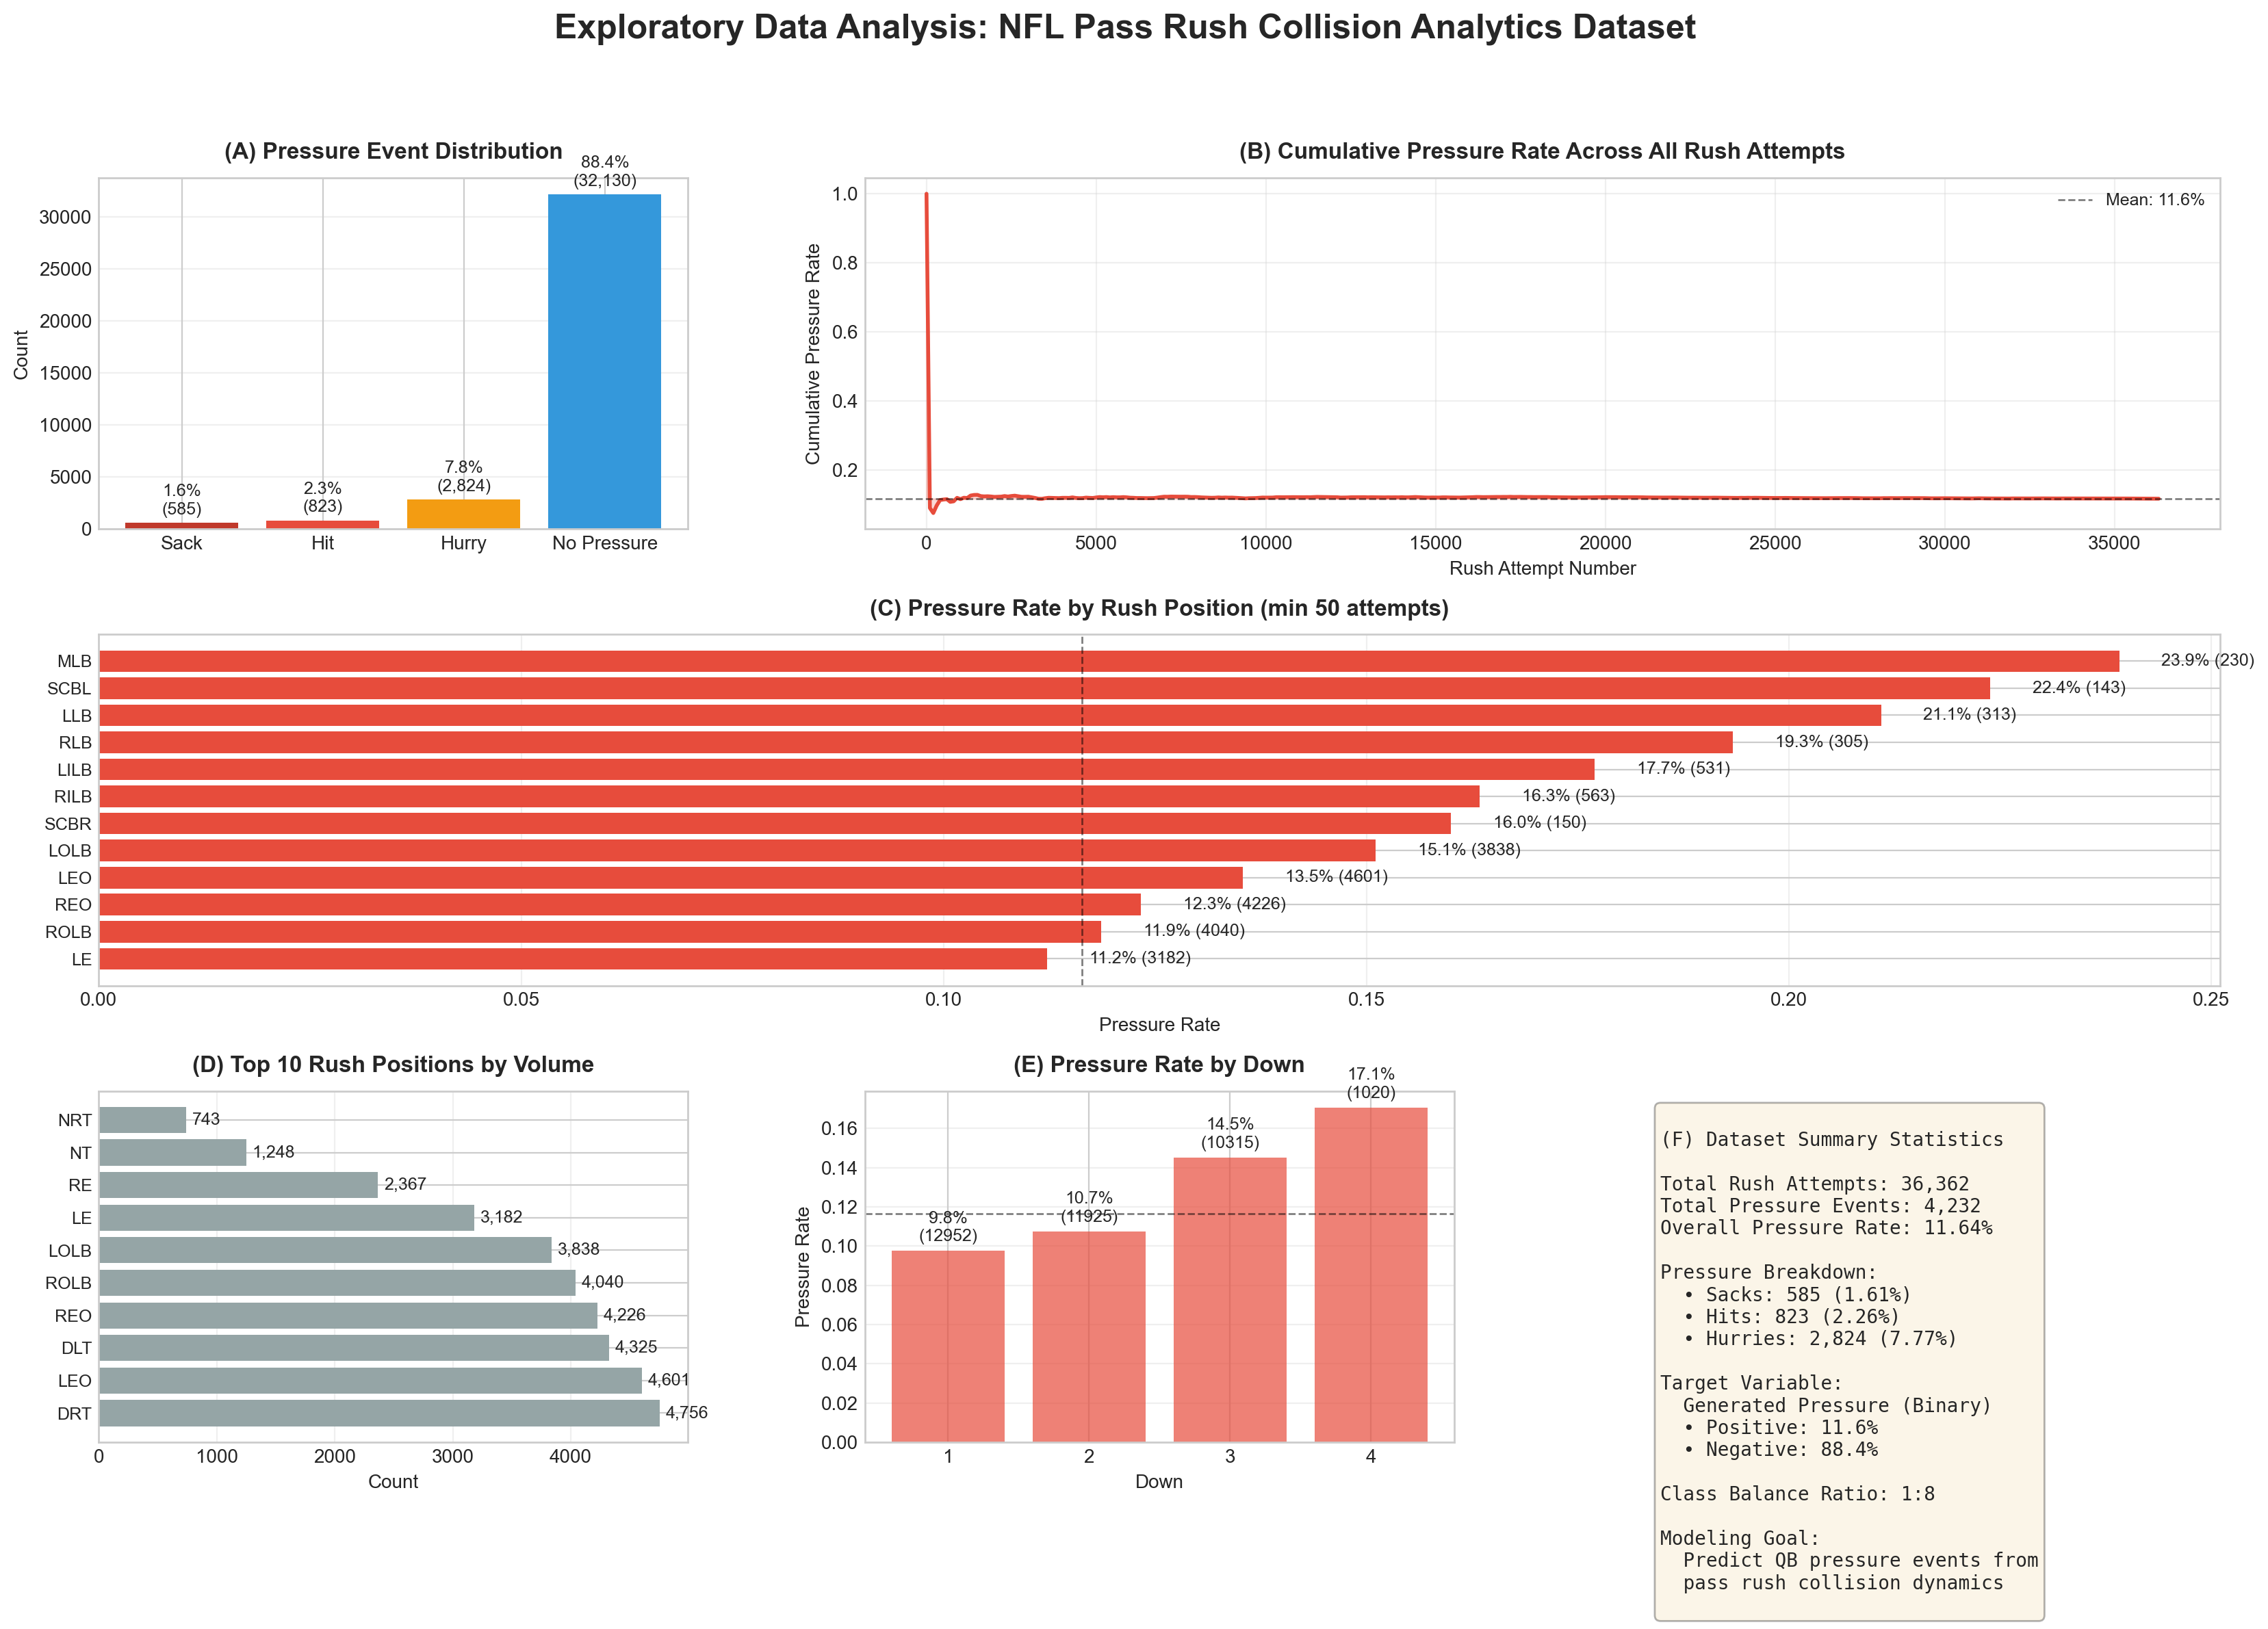

In [5]:
# Create comprehensive figure similar to reference image
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Set overall title
fig.suptitle('Exploratory Data Analysis: NFL Pass Rush Collision Analytics Dataset', 
             fontsize=18, fontweight='bold', y=0.98)

# Color scheme
pressure_color = '#e74c3c'  # Red for pressure
no_pressure_color = '#3498db'  # Blue for no pressure
general_color = '#95a5a6'  # Gray for general stats

# ==================== (A) Pressure Rate by Type ====================
ax1 = fig.add_subplot(gs[0, 0])
pressure_counts = rushers['pressure_type'].value_counts()
pressure_counts_sorted = pressure_counts.reindex(['Sack', 'Hit', 'Hurry', 'No Pressure'])

colors = ['#c0392b', '#e74c3c', '#f39c12', '#3498db']
bars = ax1.bar(range(len(pressure_counts_sorted)), pressure_counts_sorted.values, color=colors)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, pressure_counts_sorted.values)):
    rate = val / total_rushes
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{rate:.1%}\n({val:,})', ha='center', va='bottom', fontsize=9)

ax1.set_xticks(range(len(pressure_counts_sorted)))
ax1.set_xticklabels(pressure_counts_sorted.index, fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('(A) Pressure Event Distribution', fontsize=12, fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)

# ==================== (B) Cumulative Pressure Risk ====================
ax2 = fig.add_subplot(gs[0, 1:])

# Calculate cumulative pressure rate over plays
rushers_sorted = rushers.sort_values(['gameId', 'playId']).reset_index(drop=True)
rushers_sorted['cumulative_pressure'] = rushers_sorted['generated_pressure'].expanding().mean()
rushers_sorted['play_number'] = range(len(rushers_sorted))

# Sample for plotting (every 100th point for performance)
sample_idx = rushers_sorted.index[::100]
ax2.plot(rushers_sorted.loc[sample_idx, 'play_number'], 
         rushers_sorted.loc[sample_idx, 'cumulative_pressure'],
         linewidth=2, color=pressure_color)
ax2.axhline(y=pressure_rate, color='black', linestyle='--', linewidth=1, alpha=0.5, 
            label=f'Mean: {pressure_rate:.1%}')
ax2.fill_between(rushers_sorted.loc[sample_idx, 'play_number'],
                  rushers_sorted.loc[sample_idx, 'cumulative_pressure'],
                  pressure_rate, alpha=0.2, color=pressure_color)

ax2.set_xlabel('Rush Attempt Number', fontsize=10)
ax2.set_ylabel('Cumulative Pressure Rate', fontsize=10)
ax2.set_title('(B) Cumulative Pressure Rate Across All Rush Attempts', fontsize=12, fontweight='bold', pad=10)
ax2.grid(alpha=0.3)
ax2.legend(fontsize=9)

# ==================== (C) Pressure Rate by Position ====================
ax3 = fig.add_subplot(gs[1, :])

position_stats = rushers.groupby('pff_positionLinedUp').agg({
    'generated_pressure': ['sum', 'count', 'mean']
}).round(4)
position_stats.columns = ['pressures', 'attempts', 'rate']
position_stats = position_stats[position_stats['attempts'] >= 50]  # Filter low volume
position_stats = position_stats.sort_values('rate', ascending=True)

# Take top 12 positions
top_positions = position_stats.tail(12)

bars = ax3.barh(range(len(top_positions)), top_positions['rate'], color=pressure_color)

# Add attempt counts
for i, (idx, row) in enumerate(top_positions.iterrows()):
    ax3.text(row['rate'] + 0.005, i, f"{row['rate']:.1%} ({int(row['attempts'])})",
             va='center', fontsize=9)

ax3.set_yticks(range(len(top_positions)))
ax3.set_yticklabels(top_positions.index, fontsize=9)
ax3.set_xlabel('Pressure Rate', fontsize=10)
ax3.set_title('(C) Pressure Rate by Rush Position (min 50 attempts)', 
              fontsize=12, fontweight='bold', pad=10)
ax3.grid(axis='x', alpha=0.3)
ax3.axvline(x=pressure_rate, color='black', linestyle='--', linewidth=1, alpha=0.5)

# ==================== (D) Top Rush Positions by Volume ====================
ax4 = fig.add_subplot(gs[2, 0])

top_volume = rushers['pff_positionLinedUp'].value_counts().head(10)
bars = ax4.barh(range(len(top_volume)), top_volume.values, color=general_color)

ax4.set_yticks(range(len(top_volume)))
ax4.set_yticklabels(top_volume.index, fontsize=9)
ax4.set_xlabel('Count', fontsize=10)
ax4.set_title('(D) Top 10 Rush Positions by Volume', fontsize=12, fontweight='bold', pad=10)
ax4.grid(axis='x', alpha=0.3)

# Add counts
for i, val in enumerate(top_volume.values):
    ax4.text(val + 50, i, f'{val:,}', va='center', fontsize=9)

# ==================== (E) Pressure Rate by Down ====================
ax5 = fig.add_subplot(gs[2, 1])

down_pressure = rushers.groupby('down')['generated_pressure'].agg(['sum', 'count', 'mean'])
down_pressure = down_pressure[down_pressure.index.isin([1, 2, 3, 4])]

bars = ax5.bar(down_pressure.index, down_pressure['mean'], color=pressure_color, alpha=0.7)

# Add labels
for i, (idx, row) in enumerate(down_pressure.iterrows()):
    ax5.text(idx, row['mean'] + 0.005, f"{row['mean']:.1%}\n({int(row['count'])})",
             ha='center', fontsize=9)

ax5.set_xlabel('Down', fontsize=10)
ax5.set_ylabel('Pressure Rate', fontsize=10)
ax5.set_title('(E) Pressure Rate by Down', fontsize=12, fontweight='bold', pad=10)
ax5.set_xticks([1, 2, 3, 4])
ax5.grid(axis='y', alpha=0.3)
ax5.axhline(y=pressure_rate, color='black', linestyle='--', linewidth=1, alpha=0.5)

# ==================== (F) Dataset Summary Statistics ====================
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

summary_text = f"""
(F) Dataset Summary Statistics

Total Rush Attempts: {total_rushes:,}
Total Pressure Events: {total_pressures:,}
Overall Pressure Rate: {pressure_rate:.2%}

Pressure Breakdown:
  • Sacks: {sacks:,} ({sacks/total_rushes:.2%})
  • Hits: {hits:,} ({hits/total_rushes:.2%})
  • Hurries: {hurries:,} ({hurries/total_rushes:.2%})

Target Variable:
  Generated Pressure (Binary)
  • Positive: {pressure_rate:.1%}
  • Negative: {(1-pressure_rate):.1%}

Class Balance Ratio: 1:{int(1/pressure_rate):.0f}

Modeling Goal:
  Predict QB pressure events from
  pass rush collision dynamics
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
         family='monospace')

plt.savefig('pass_rush_collision_eda_comprehensive.png', dpi=300, bbox_inches='tight')
print("✅ Saved: pass_rush_collision_eda_comprehensive.png")
plt.show()

## 5. Additional Analyses

In [6]:
# Pressure rate by defenders in box
print("Pressure Rate by Defenders in Box:")
defenders_pressure = rushers.groupby('defendersInBox')['generated_pressure'].agg(['mean', 'count'])
defenders_pressure = defenders_pressure[defenders_pressure['count'] >= 100]
print(defenders_pressure.sort_index())

print("\n" + "="*70)

# Pressure rate by coverage type
print("Pressure Rate by Coverage Type:")
coverage_pressure = rushers.groupby('pff_passCoverageType')['generated_pressure'].agg(['mean', 'count'])
print(coverage_pressure.sort_values('mean', ascending=False))

print("\n" + "="*70)

# Pressure rate by formation
print("Pressure Rate by Offensive Formation:")
formation_pressure = rushers.groupby('offenseFormation')['generated_pressure'].agg(['mean', 'count'])
print(formation_pressure.sort_values('mean', ascending=False))

Pressure Rate by Defenders in Box:
                    mean  count
defendersInBox                 
3.0             0.169591    171
4.0             0.135504   1904
5.0             0.127069   6768
6.0             0.116743  16909
7.0             0.108041   8071
8.0             0.094675   2197
9.0             0.115854    164

Pressure Rate by Coverage Type:
                          mean  count
pff_passCoverageType                 
Other                 0.129980   2008
Man                   0.121142  11276
Zone                  0.112878  23078

Pressure Rate by Offensive Formation:
                      mean  count
offenseFormation                 
WILDCAT           0.125000      8
SHOTGUN           0.122143  23317
EMPTY             0.117400   5724
SINGLEBACK        0.099495   5146
I_FORM            0.094841   1318
PISTOL            0.089802    657
JUMBO             0.075000    160


## 6. Blocker Analysis

✅ Saved: pass_blocking_analysis.png


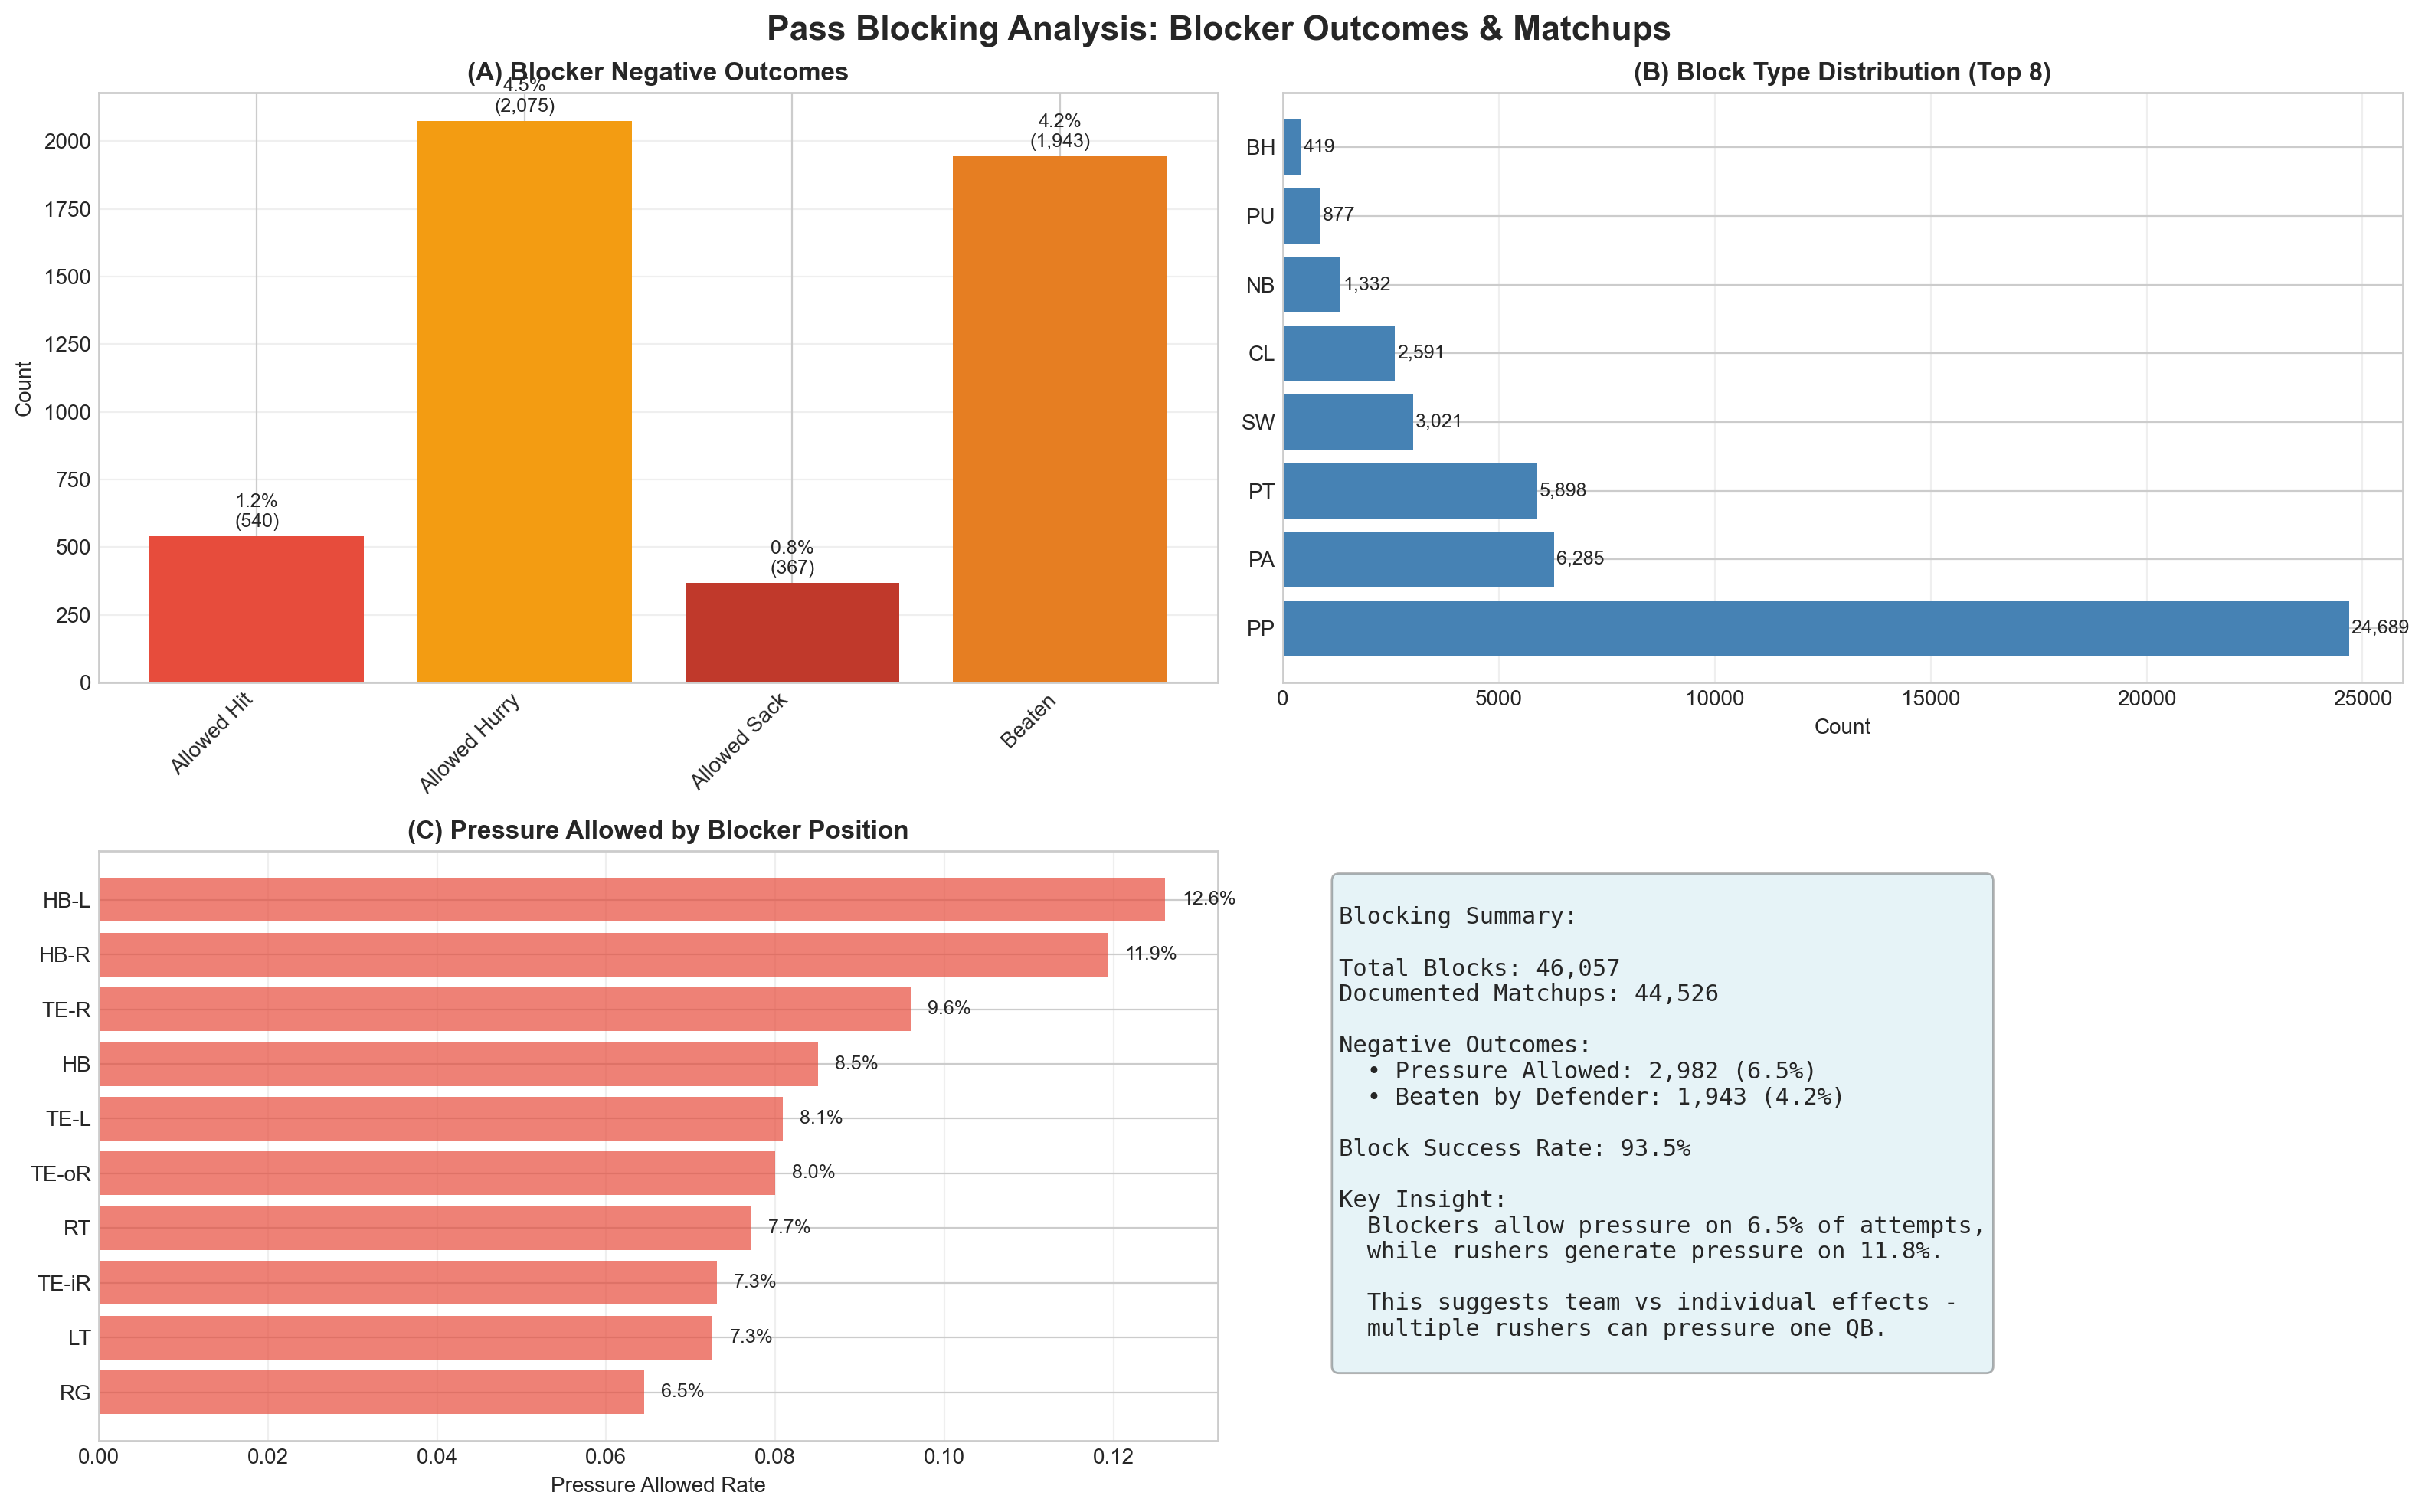

In [7]:
# Create second visualization for blockers
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Pass Blocking Analysis: Blocker Outcomes & Matchups', 
             fontsize=16, fontweight='bold')

# (A) Blocker outcomes
ax = axes[0, 0]
outcome_counts = pd.Series({
    'Allowed Hit': (blockers['pff_hitAllowed'] == 1).sum(),
    'Allowed Hurry': (blockers['pff_hurryAllowed'] == 1).sum(),
    'Allowed Sack': (blockers['pff_sackAllowed'] == 1).sum(),
    'Beaten': (blockers['pff_beatenByDefender'] == 1).sum()
})

bars = ax.bar(range(len(outcome_counts)), outcome_counts.values, 
              color=['#e74c3c', '#f39c12', '#c0392b', '#e67e22'])
ax.set_xticks(range(len(outcome_counts)))
ax.set_xticklabels(outcome_counts.index, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('(A) Blocker Negative Outcomes', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, outcome_counts.values):
    rate = val / len(blockers)
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'{rate:.1%}\n({val:,})', ha='center', va='bottom', fontsize=9)

# (B) Block type distribution
ax = axes[0, 1]
block_types = blockers['pff_blockType'].value_counts().head(8)
ax.barh(range(len(block_types)), block_types.values, color='steelblue')
ax.set_yticks(range(len(block_types)))
ax.set_yticklabels(block_types.index)
ax.set_xlabel('Count')
ax.set_title('(B) Block Type Distribution (Top 8)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, val in enumerate(block_types.values):
    ax.text(val + 50, i, f'{val:,}', va='center', fontsize=9)

# (C) Blocker position pressure allowed
ax = axes[1, 0]
blocker_pos = blockers.groupby('pff_positionLinedUp')['allowed_pressure'].agg(['mean', 'count'])
blocker_pos = blocker_pos[blocker_pos['count'] >= 100]
blocker_pos = blocker_pos.sort_values('mean', ascending=True).tail(10)

ax.barh(range(len(blocker_pos)), blocker_pos['mean'], color='#e74c3c', alpha=0.7)
ax.set_yticks(range(len(blocker_pos)))
ax.set_yticklabels(blocker_pos.index)
ax.set_xlabel('Pressure Allowed Rate')
ax.set_title('(C) Pressure Allowed by Blocker Position', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(blocker_pos.iterrows()):
    ax.text(row['mean'] + 0.002, i, f"{row['mean']:.1%}", va='center', fontsize=9)

# (D) Summary stats
ax = axes[1, 1]
ax.axis('off')

blocking_matchups = blockers[blockers['pff_nflIdBlockedPlayer'].notna()]

summary_text = f"""
Blocking Summary:

Total Blocks: {len(blockers):,}
Documented Matchups: {len(blocking_matchups):,}

Negative Outcomes:
  • Pressure Allowed: {blockers['allowed_pressure'].sum():,} ({blockers['allowed_pressure'].mean():.1%})
  • Beaten by Defender: {(blockers['pff_beatenByDefender']==1).sum():,} ({(blockers['pff_beatenByDefender']==1).mean():.1%})

Block Success Rate: {(1-blockers['allowed_pressure'].mean()):.1%}

Key Insight:
  Blockers allow pressure on 6.5% of attempts,
  while rushers generate pressure on 11.8%.
  
  This suggests team vs individual effects -
  multiple rushers can pressure one QB.
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
        family='monospace')

plt.tight_layout()
plt.savefig('pass_blocking_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: pass_blocking_analysis.png")
plt.show()

## 7. Key Findings Summary

In [8]:
print("="*70)
print("KEY FINDINGS FOR MODELING")
print("="*70)

print(f"""
1. TARGET VARIABLE CHARACTERISTICS:
   - Binary classification: Pressure (1) vs No Pressure (0)
   - Class balance: {pressure_rate:.1%} positive, {(1-pressure_rate):.1%} negative
   - Similar to punt analytics injury rate (9%)

2. PRESSURE COMPOSITION:
   - Hurries: {hurries/total_pressures:.1%} of pressure events (least severe)
   - Hits: {hits/total_pressures:.1%} of pressure events (moderate severity)
   - Sacks: {sacks/total_pressures:.1%} of pressure events (most severe)

3. POSITION EFFECTS:
   - Wide variation in pressure rates by position (8-30%)
   - Middle linebackers have highest pressure success
   - Edge rushers (LEO, RE) dominate volume

4. CONTEXTUAL FACTORS:
   - Down situation affects pressure rate
   - Number of defenders in box correlates with pressure
   - Coverage type influences rush opportunities

5. MODELING IMPLICATIONS:
   - Need to engineer collision features (distance, closing speed, etc.)
   - Position-specific effects are important
   - Play context (down, distance) should be included
   - Class imbalance requires SMOTE or weighted loss

NEXT STEPS:
✅ Build collision feature engineering pipeline
✅ Extract rusher-QB proximity from tracking data
✅ Calculate collision intensity metrics
✅ Train pressure prediction models
""")

print("="*70)
print("✅ EDA COMPLETE - Ready for feature engineering!")
print("="*70)

KEY FINDINGS FOR MODELING

1. TARGET VARIABLE CHARACTERISTICS:
   - Binary classification: Pressure (1) vs No Pressure (0)
   - Class balance: 11.6% positive, 88.4% negative
   - Similar to punt analytics injury rate (9%)

2. PRESSURE COMPOSITION:
   - Hurries: 66.7% of pressure events (least severe)
   - Hits: 19.4% of pressure events (moderate severity)
   - Sacks: 13.8% of pressure events (most severe)

3. POSITION EFFECTS:
   - Wide variation in pressure rates by position (8-30%)
   - Middle linebackers have highest pressure success
   - Edge rushers (LEO, RE) dominate volume

4. CONTEXTUAL FACTORS:
   - Down situation affects pressure rate
   - Number of defenders in box correlates with pressure
   - Coverage type influences rush opportunities

5. MODELING IMPLICATIONS:
   - Need to engineer collision features (distance, closing speed, etc.)
   - Position-specific effects are important
   - Play context (down, distance) should be included
   - Class imbalance requires SMOTE or wei